# Getting started with monarch
This notebook demonstrates how the monarch package can be used to simulate cardiac physiology and mechanics. We will demonstrate how the model can be run and results be visualized and analyzed, and share some example cases. This notebook focuses on single-beat analyses only, growth simulations are covered in the `growth` notebook.

In [79]:
# Jupyter magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic usage
### Running a single cardiac cycle

We first need to initialize the model and import it into this notebook. We will use an input file containing input parameters that simulate a representative human case. By initializing the model, the parameters from the JSON-format input file are being imported, and some initial arrays are pre-allocated, such as time, and compartmental pressures and volumes. You can create your own input file using the included examples.

In [80]:
from monarch.egg import Monarch
import pathlib

# Initialize model
input_dir = pathlib.Path.cwd() / "input_files"
input_human = input_dir / 'human'
beat = Monarch(input_human)

To simulate a single cardiac cycle, we call on the core function of the model: `just_beat_it`. This will simulate a cardiac cycle using the built-in 4th-order Rung-Kutta solver using the initial conditions provided in the input file parameter `k`. After running one cardiac cycle, the solver checks if a steady-state circulation has been reached by comparing the differences between the initial and final blood volumes in all compartments. If these differences are below a certain threshold (default 1e-6), the model is considered to have converged. If the model has not converged, the solver will run another cardiac cycle with the final volumes set as the new initial conditions. The solver will continue to run cardiac cycles until the model has converged. The solver will also stop if the maximum number of iterations is reached (input file parameter `iter_max`). The solver will print the volume error in each compartment if the `print_solve` parameter is set to `True` (default `False`). The first time this code is executed, the function is much slower, because the python code has to be compiled first into machine code using Numba. All the following times the function is called, the compiled code is used, and the function is much faster.

In [81]:
# Run model and display convergence
beat.just_beat_it(print_solve=True)

Iteration 0:	2.59e-01 2.61e-01 1.06e-01 8.88e-02 7.64e-02 2.59e-01 2.69e-01 1.44e-01
Iteration 1:	9.75e-02 1.11e-02 2.67e-02 1.32e-02 1.10e-02 5.83e-04 9.91e-03 2.36e-02
Iteration 2:	6.42e-02 7.47e-03 1.96e-02 1.48e-02 7.42e-03 7.85e-04 1.32e-02 1.31e-02
Iteration 3:	4.20e-02 4.97e-03 1.37e-02 1.25e-02 5.06e-03 5.09e-04 9.16e-03 8.08e-03
Iteration 4:	2.73e-02 3.26e-03 9.36e-03 9.34e-03 3.30e-03 3.18e-04 6.18e-03 5.18e-03
Iteration 5:	1.77e-02 2.13e-03 6.27e-03 6.62e-03 2.06e-03 1.94e-04 4.10e-03 3.41e-03
Iteration 6:	1.14e-02 1.37e-03 4.12e-03 4.54e-03 1.23e-03 1.15e-04 2.68e-03 2.29e-03
Iteration 7:	7.23e-03 8.79e-04 2.67e-03 3.05e-03 7.00e-04 6.48e-05 1.73e-03 1.56e-03
Steady-state circulation established


### Visualizing the results
The module `metamorphoses` includes a series of convenient plotting functions on the Monarch class. For example, we can plot the pressure-volume loops of the left and right ventricles:

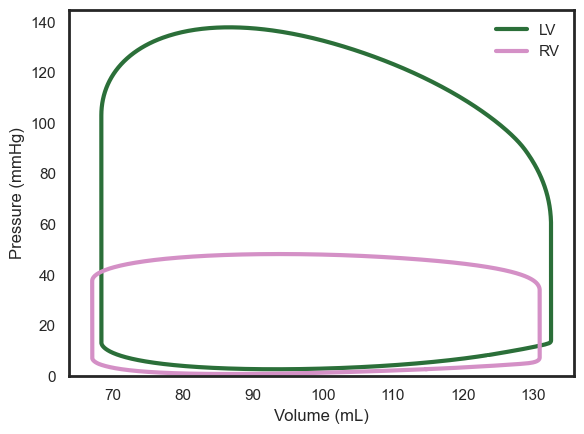

In [82]:
# Import plotting functions
from monarch import metamophoses as meta

# Plot LV pressure-volume loop
meta.pv_loop(beat, compartments=("LV", "RV"))

Note that figures can be exported by specifying a `file_path` parameter (`filename` has a default but can user-specified too), as well as export format `file_format` (default `.pdf`). Figure display can be disabled by setting `show_fig=False`. The following cell will only export the figure in the same directory as this notebook and not display it:

In [83]:
meta.pv_loop(beat, compartments=("LV", "RV"), show_fig=False, file_path='./')

We can also plot the Wiggers diagram, which is useful to analyze LV behaviour:

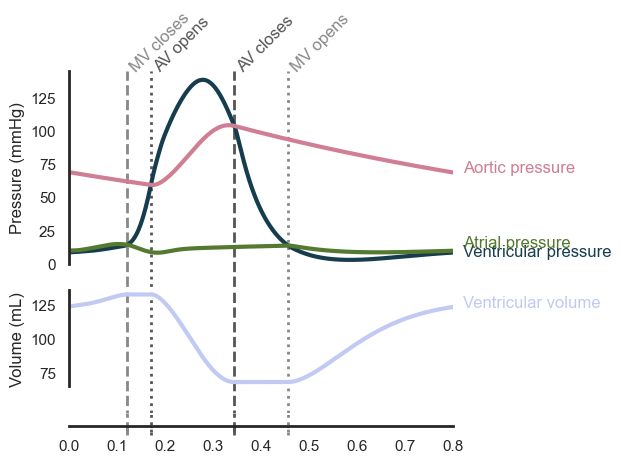

In [84]:
meta.wiggers_diagram(beat)

there is also a function to plot all pressures and volumes, which is useful to compare the different compartments and for code debugging and development:

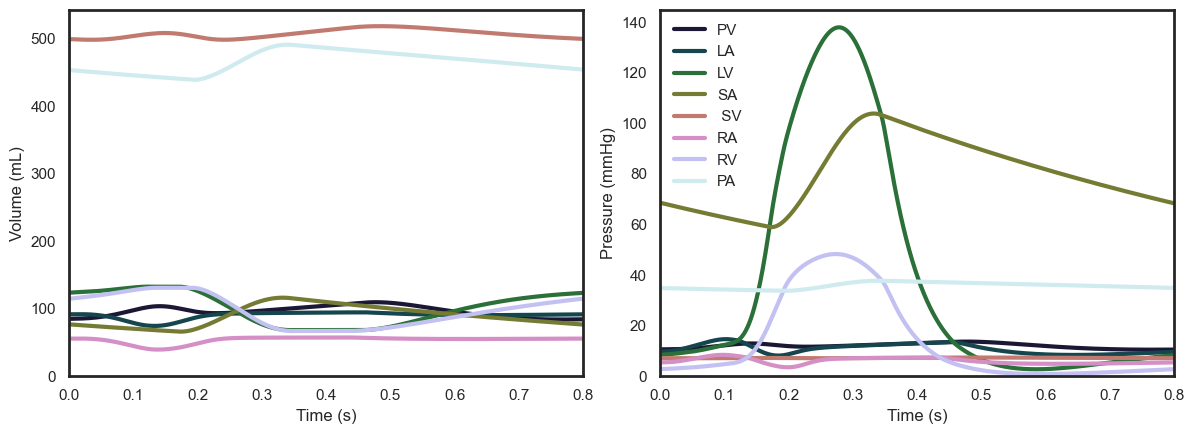

In [85]:
meta.pressures_volumes(beat)

Another useful tool is that a range of typical physiological readouts are calculated and stored in a Pandas table format:

In [86]:
from IPython.display import display
display(beat.outputs)

,LVEDV,LVESV,LVEDP,LVESP,LVMaxP,LVMaxdP,LVMindP,LVSV,LVRF,LVEF,...,TES,IED_RV,IES_RV,TED_RV,TES_RV,LAP,LVEDVi,LVESVi,RVEDVi,RVESVi
0,132.609604,68.303814,14.195614,103.155085,137.920998,1731.714409,-1457.345657,64.30579,0.0,0.484926,...,0.344191,305,777,0.135631,0.345525,10.834654,NaN,NaN,NaN,NaN


### Import and export
The Monarch class can import and export the results of a simulation. The key results are stored in .hdf5 format to maximize compatibility with all software versions and operating systems. We here store the results of the current simulation in the same directory as this notebook:


In [87]:
import pathlib

# Get current directory
cdir = pathlib.Path.cwd()

# Export results
beat.export_beat_sim(cdir, "demo")

The results can be imported again into an existing or new Monarch class. Here we demonstrate how to export the results and show that the results of the new class are the same as the original class:

In [88]:
# Start new class and load previous results
beat_load = Monarch(input_human)
beat_load.import_beat_sim(cdir, "demo")

display(beat.outputs)
display(beat_load.outputs)

,LVEDV,LVESV,LVEDP,LVESP,LVMaxP,LVMaxdP,LVMindP,LVSV,LVRF,LVEF,...,TES,IED_RV,IES_RV,TED_RV,TES_RV,LAP,LVEDVi,LVESVi,RVEDVi,RVESVi
0,132.609604,68.303814,14.195614,103.155085,137.920998,1731.714409,-1457.345657,64.30579,0.0,0.484926,...,0.344191,305,777,0.135631,0.345525,10.834654,NaN,NaN,NaN,NaN


,LVEDV,LVESV,LVEDP,LVESP,LVMaxP,LVMaxdP,LVMindP,LVSV,LVRF,LVEF,...,TES,IED_RV,IES_RV,TED_RV,TES_RV,LAP,LVEDVi,LVESVi,RVEDVi,RVESVi
0,132.609604,68.303814,14.195614,103.155085,137.920998,1731.714409,-1457.345657,64.30579,0.0,0.484926,...,0.344191,305.0,777.0,0.135631,0.345525,10.834654,NaN,NaN,NaN,NaN


Additionally, the converged model states are by default stored in a JSON file in the source code directory, which can be imported when rerunning a new simulation. This is useful for example when you want to run a series of simulations with similar parameters, thus reducing the amount of iterations required to reach convergence and reducing computation time. However, when running a model with substantially different parameters it can lead to convergence issues, that is why it is by default disabled–also, the model is so fast that the difference is typically negligible. You can also delete the converged solution JSON file to ensure the model starts from a clean slate when using converged solution imports. We here show the different amount of solver iterations needed to reach convergence with and without using the converged solution:

In [89]:
print("Run 1: standard, do not use converged solution")
beat = Monarch(input_human)
beat.just_beat_it(print_solve=True)

print("\nRun 2: use converged solution")
beat = Monarch(input_human)
beat.just_beat_it(print_solve=True, use_converged=True)

print("\nRun 3: clear converged solution")
beat = Monarch(input_human)
beat.clear_converged_sol()
beat.just_beat_it(print_solve=True, use_converged=True)

Run 1: standard, do not use converged solution
Iteration 0:	2.59e-01 2.61e-01 1.06e-01 8.88e-02 7.64e-02 2.59e-01 2.69e-01 1.44e-01
Iteration 1:	9.75e-02 1.11e-02 2.67e-02 1.32e-02 1.10e-02 5.83e-04 9.91e-03 2.36e-02
Iteration 2:	6.42e-02 7.47e-03 1.96e-02 1.48e-02 7.42e-03 7.85e-04 1.32e-02 1.31e-02
Iteration 3:	4.20e-02 4.97e-03 1.37e-02 1.25e-02 5.06e-03 5.09e-04 9.16e-03 8.08e-03
Iteration 4:	2.73e-02 3.26e-03 9.36e-03 9.34e-03 3.30e-03 3.18e-04 6.18e-03 5.18e-03
Iteration 5:	1.77e-02 2.13e-03 6.27e-03 6.62e-03 2.06e-03 1.94e-04 4.10e-03 3.41e-03
Iteration 6:	1.14e-02 1.37e-03 4.12e-03 4.54e-03 1.23e-03 1.15e-04 2.68e-03 2.29e-03
Iteration 7:	7.23e-03 8.79e-04 2.67e-03 3.05e-03 7.00e-04 6.48e-05 1.73e-03 1.56e-03
Steady-state circulation established

Run 2: use converged solution
Iteration 0:	7.23e-03 8.79e-04 2.68e-03 3.04e-03 7.01e-04 6.49e-05 1.73e-03 1.56e-03
Steady-state circulation established

Run 3: clear converged solution
Iteration 0:	2.59e-01 2.61e-01 1.06e-01 8.88e-02 7

## Examples
Now that we can run and plot a single cardiac cycle, we can test what happens to the model outcomes if change certain model parameters.

### Example 1: Heart rate
Let's first run two cardiac cycles with different heart rates: 60 and 90 bpm. We can use the built-in method *change_pars* to conveniently change any parameter, here we change the heart rate parameter. We will run multiple heart beats and plot the pressure-volume loops of the left ventricle to observe the effect of heart rate on stroke volume and cardiac output:

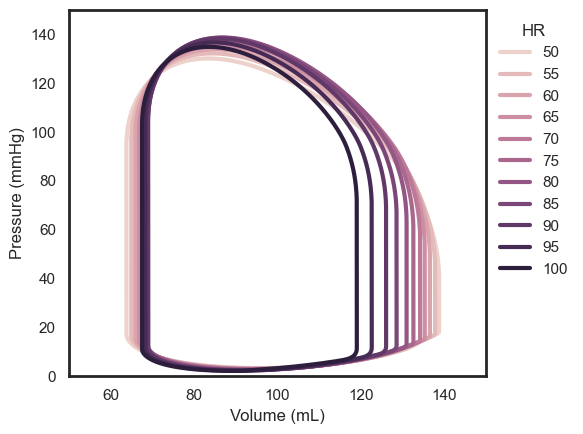

In [90]:
import numpy as np

# Preallocate beats and choose heart rates
beats = []
heart_rates = np.arange(50, 101, 5)

# Simulate each heart rate
for hr in heart_rates:
    # Initialize and set HR
    beat = Monarch(input_human)
    beat.change_pars({"HR": hr})
    
    # Run model and store results
    beat.just_beat_it()
    beats.append(beat)

# Plot multiple PV loops of a single compartment, default LV
meta.pv_loops(beats, model_names=heart_rates, var_name="HR", y_lim=(0, 150), x_lim=(50, 150))

Note that the stroke volume decreases with increasing heart rate. This is due to the Frank-Starling law: the shorter filling time decreases end-diastolic volume which in turn decreases contractility. However, the increasing heart rate does lead to an increase in stroke volume. Let's use the output tables to proof that our model obeys the Frank-Starling law:

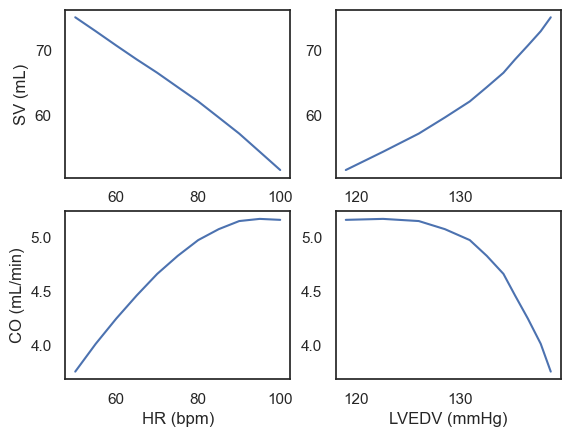

In [91]:
import matplotlib.pyplot as plt

# Extract outputs of all simulations
sv, co, hr, lvedv = [], [], [], []
for beat in beats:
    hr.append(beat.outputs["HR"]) 
    sv.append(beat.outputs["LVSV"])
    co.append(beat.outputs["LVCO"])
    lvedv.append(beat.outputs["LVEDV"])

# Plot results
fig, ax  = plt.subplots(2, 2)
ax[0, 0].plot(hr, sv)
ax[1, 0].plot(hr, co)
ax[0, 1].plot(lvedv, sv)
ax[1, 1].plot(lvedv, co)

ax[1, 0].set_xlabel("HR (bpm)")
ax[1, 1].set_xlabel("LVEDV (mmHg)")
ax[0, 0].set_ylabel("SV (mL)")
ax[1, 0].set_ylabel("CO (mL/min)")

plt.show()

### Example 2: Myocardial ischemia
Myocardial ischemia, commonly known as a heart attack, occurs when blood flow to the heart muscle is reduced or blocked, preventing the heart muscle from receiving enough oxygen. This can lead to cell death and scar tissue formation. We can simulate the initial ischemia by setting the contractility of a region to zero. We will simulate a healthy baseline and an ischemic septal case:

In [92]:
# Initialize and run healthy baseline model
beat_baseline = Monarch(input_human)
beat_baseline.just_beat_it()

# Set septal wall to be ischemic and rerun simulation
beat_ischemic = Monarch(input_human)
beat_ischemic.heart.sf_act[2] = 0.0
beat_ischemic.just_beat_it()

We then plot the pressure-volume loops to observe the effect of ischemia on the heart's function, notice how the stroke volume decreases, end-diastolic pressure increases, and end-systolic pressure decrease in the ischemic case. Note that this is without any hemodynamic reflexes, that is the body compensating for the reduction in stroke volume by increasing heart rate, contractility, and/or preload.

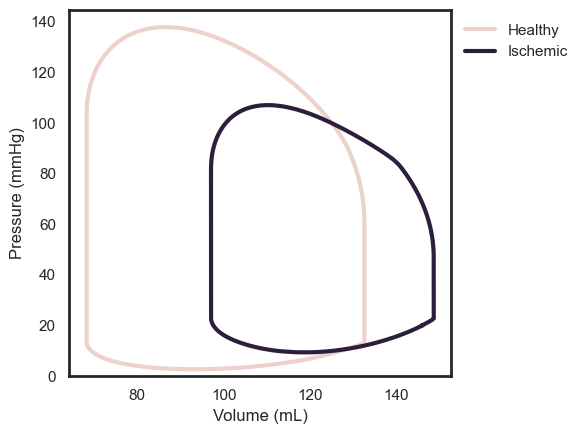

In [93]:
meta.pv_loops([beat_baseline, beat_ischemic], model_names=["Healthy", "Ischemic"])

We can also plot stretch to reveal the typical behavior of a myocardial ischemic region: the now-ischemic septal wall (SW) experiences pre-load during early contraction of the left and right free walls (LFW and RFW), and does not contract at all. Note that in this simulation resembles acute ischemia: there is no remodeling, typically this could comprise of scar formation and subsequent wall thinning in the ischemic region, and hypertrophy of the healthy, remote regions. The latter can be simulated using our growth functions.

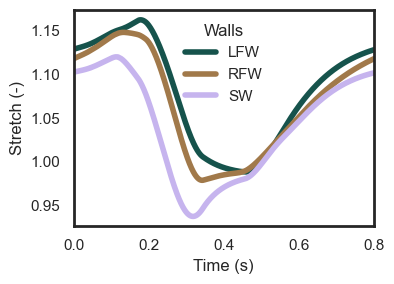

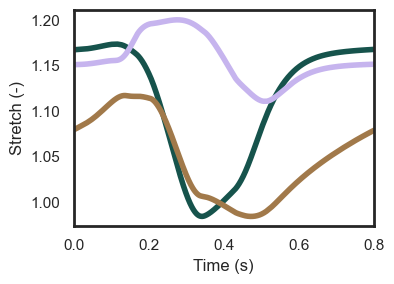

In [94]:
meta.stretch(beat_baseline, fig_size=(4, 3))
meta.stretch(beat_ischemic, fig_size=(4, 3), legend=False)

### Example 3: Activation timing
This model was specifically designed to simulate dyssynchronous heart failure. The ventricular composite geometry consists of three spherical walls based on the TriSeg method [3], and each wall can be split into a series of individual segments, or patches [3]. Each patch can be assigned a different activation timing through the `*`heart.t_act`*` parameter, where each value stands for a patch, and the wall each patch is located in is specified in `heart.patches`, where left free wall is 0, right wall is 1, septal wall is 2, left atrium is 3, and right atrium is 4. Not that the other cardiac parameters need to be set for each patch as well, which comes with pros and cons: each patch can be assigned different properties, but now each parameter requires a list of specified values equal to the number of patches.

The input file `input_oomen2022` has patches are set up according to the 16-segment AHA model, with 5 patches in the septal wall and 11 in the left free wall. Additionally, the right free wall is split up into 5 patches, while the atria are single-patch spheres. This input file is based on [1], note however the code version used for that paper included several differences, most notably no atria, so the results will be slightly different. Moreover, the results for that paper were generated using the original MATLAB version of this code, which is still publicly available on GitHub. The single-beat cases simulated here also do not include hemodynamic compensation through blood volume and arterial resistance, but they are included in the growth simulations using this same input file.

Start with a healthy baseline heart beat:

In [95]:
input_canine = input_dir / 'oomen2022'
beat_baseline = Monarch(input_canine)
beat_baseline.just_beat_it()

Using this input file, we can simulate a left bundle branch block (LBBB) and cardiac resynchronization therapy (CRT) case. We will set the activation timing using the activation times stored in the growth part of the input, see the growth notebook for more information.

In [96]:
beat_lbbb = Monarch(input_canine)
beat_lbbb.change_pars({"tact": beat_lbbb.growth.t_act[1, :]})
beat_lbbb.just_beat_it()

beat_crt = Monarch(input_canine)
beat_crt.change_pars({"tact": beat_crt.growth.t_act[-1, :]})
beat_crt.just_beat_it()

 We will then plot the pressure-volume loops and stretch to observe the effect of activation timing on cardiac function, with LBBB causing a decrease in stroke volume and CRT an almost complete recovery of stroke volume:

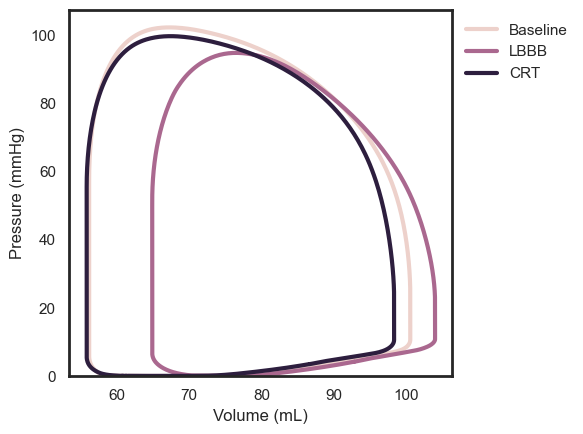

In [97]:
meta.pv_loops([beat_baseline, beat_lbbb, beat_crt], model_names=["Baseline", "LBBB", "CRT"])

Plotting the stretch reveals the typical behavior of LBBB and CRT: LBBB causes a delay in activation, increased preload, and increased work of the left free wall, while the septal contracts less and rebound stretch is noticable in several patches, however less than seen in a typical ultrasound or MRI. CRT mostly recovers these effects towards baseline:

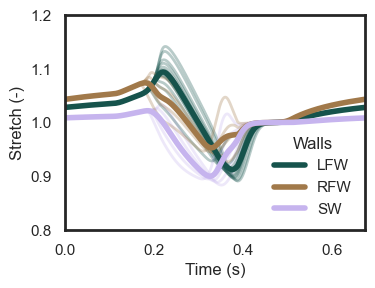

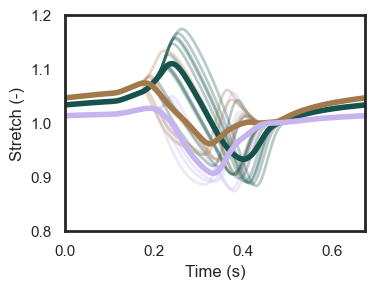

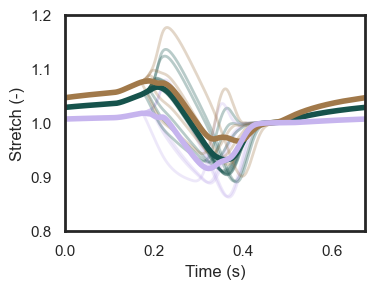

In [98]:
meta.stretch(beat_baseline, fig_size=(4, 3), y_lim=(0.8, 1.2))
meta.stretch(beat_lbbb, fig_size=(4, 3), legend=False, y_lim=(0.8, 1.2))
meta.stretch(beat_crt, fig_size=(4, 3), legend=False, y_lim=(0.8, 1.2))

## References
[1] Oomen, P. J. A., Phung, T.-K. N., Weinberg, S. H., Bilchick, K. C. & Holmes, J. W. A rapid electromechanical model to predict reverse remodeling following cardiac resynchronization therapy. Biomech Model Mechan 21, 231–247 (2022).
[2] Lumens, J., Delhaas, T., Kirn, B. & Arts, T. Three-Wall Segment (TriSeg) Model Describing Mechanics and Hemodynamics of Ventricular Interaction. Ann Biomed Eng 37, 2234–2255 (2009).
[3] Walmsley, J. et al. Fast Simulation of Mechanical Heterogeneity in the Electrically Asynchronous Heart Using the MultiPatch Module. Plos Comput Biol 11, e1004284 (2015).
  
   
  